# LSTM Model using Therapy sequence

In [30]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, SensitivityAtSpecificity
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
#internal validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pickle

# fix random seed for reproducibility
tf.random.set_seed(1234)

target_outcome = 'outcome_combined_12months'
max_codes = 50

In [31]:
# load the dataset but only keep the top n words, zero the rest
data = pickle.load(open('../SeqModel/data_therapy.sav', 'rb'))
code2idx = pickle.load(open('../SeqModel/code2idx_therapy.sav', 'rb'))
idx2code = pickle.load(open('../SeqModel/idx2code_therapy.sav', 'rb'))

vocab_size = len(code2idx)
vocab_size

6021

In [32]:
# #Data split conventional (mixed countries)
# trainingData, testData = train_test_split(data, test_size=0.1, stratify=data[target_outcome], random_state=1234)
# trainingData, valData = train_test_split(trainingData, test_size=0.2, stratify=trainingData[target_outcome], random_state=1234)
# print(trainingData.shape)
# print(valData.shape)
# print(testData.shape)

In [33]:
#Data split, train=England, eval=Scot+Wales
trainingData = data[(data.Country == 'England') & (data.age >= 18)]
trainingData, valData = train_test_split(trainingData, test_size=0.2, stratify=trainingData[target_outcome], random_state=1234)
trainingData, evalData = train_test_split(trainingData, test_size=0.2, stratify=trainingData[target_outcome], random_state=1234)
testData = data[((data.Country == 'Wales') | (data.Country == 'Scotland')) & (data.age >= 18)]
testDataWales = data[(data.Country == 'Wales') & (data.age >= 18)]
testDataScotland = data[(data.Country == 'Scotland') & (data.age >= 18)]

In [34]:
print('Train: ', trainingData.shape[0])
print('Val: ', valData.shape[0])
print('Eval (internal validation): ', evalData.shape[0])
print('Test: ', testData.shape[0])
print('Test - Wales: ', testDataWales.shape[0])
print('Test - Scotland: ', testDataScotland.shape[0])

Train:  9679
Val:  3025
Eval (internal validation):  2420
Test:  1263
Test - Wales:  844
Test - Scotland:  419


In [35]:
print(trainingData.patid.unique().shape)
print(trainingData.shape)

(9679,)
(9679, 14)


In [36]:
#make sure no data leak between sets
print(list(set(trainingData.patid.values).intersection(set(valData.patid.values))))
print(list(set(trainingData.patid.values).intersection(set(evalData.patid.values))))
print(list(set(valData.patid.values).intersection(set(evalData.patid.values))))
print(list(set(valData.patid.values).intersection(set(testData.patid.values))))
print(list(set(trainingData.patid.values).intersection(set(testData.patid.values))))
print(list(set(testData.patid.values).intersection(set(testDataScotland.patid.values)))) # here data leak is expected

[]
[]
[]
[]
[]
[43487233, 43487235, 43464708, 43378699, 43139096, 43378721, 43165731, 43487269, 43165746, 43325496, 43311166, 43464772, 43227211, 43378773, 43311191, 43339865, 43139165, 43284586, 43374709, 43139214, 43315349, 43165847, 43430042, 43442340, 43145381, 43327661, 43350191, 43491513, 43315386, 43135161, 43145404, 43253954, 43430083, 43190477, 43339982, 43190478, 43253966, 43303126, 43423963, 43430108, 43426012, 43317488, 43340029, 43317502, 43190531, 43317508, 43204870, 43491591, 43340044, 43317518, 43430159, 43190548, 43317526, 43208987, 43315486, 43317538, 43208998, 43317543, 43209011, 43430199, 43430210, 43413830, 43489611, 43340108, 43209038, 43340118, 43477336, 43491683, 43272551, 43413865, 43342206, 43413898, 43336077, 43209102, 43342222, 43489683, 43426195, 43489687, 43188637, 43491760, 43262384, 43145648, 43262393, 43426234, 43420103, 43336137, 43426256, 43373014, 43188697, 43188698, 43491804, 43426270, 43373023, 43489770, 43416050, 43336187, 43188732, 43354623, 4318

In [37]:
print(trainingData[target_outcome].value_counts(normalize=True))
print(valData[target_outcome].value_counts(normalize=True))
print(evalData[target_outcome].value_counts(normalize=True))
print(testData[target_outcome].value_counts(normalize=True))
print(testDataWales[target_outcome].value_counts(normalize=True))
print(testDataScotland[target_outcome].value_counts(normalize=True))

0    0.797603
1    0.202397
Name: outcome_combined_12months, dtype: float64
0    0.797686
1    0.202314
Name: outcome_combined_12months, dtype: float64
0    0.797521
1    0.202479
Name: outcome_combined_12months, dtype: float64
0    0.722882
1    0.277118
Name: outcome_combined_12months, dtype: float64
0    0.720379
1    0.279621
Name: outcome_combined_12months, dtype: float64
0    0.727924
1    0.272076
Name: outcome_combined_12months, dtype: float64


In [38]:
# X and y
X_train = np.array(trainingData.read_code_seq_padded_idx.values)
X_train = np.array([x for x in X_train])
X_val = np.array(valData.read_code_seq_padded_idx.values)
X_val = np.array([x for x in X_val])
X_eval = np.array(evalData.read_code_seq_padded_idx.values)
X_eval = np.array([x for x in X_eval])
X_test = np.array(testData.read_code_seq_padded_idx.values)
X_test = np.array([x for x in X_test])
X_testWales = np.array(testDataWales.read_code_seq_padded_idx.values)
X_testWales = np.array([x for x in X_testWales])
X_testScotland = np.array(testDataScotland.read_code_seq_padded_idx.values)
X_testScotland = np.array([x for x in X_testScotland])

y_train = trainingData[target_outcome].values
y_val = valData[target_outcome].values
y_eval = evalData[target_outcome].values
y_test = testData[target_outcome].values
y_testWales = testDataWales[target_outcome].values
y_testScotland = testDataScotland[target_outcome].values

In [39]:
print('Train: ', X_train.shape)
print('Val: ', X_val.shape[0])
print('Eval (internal validation): ', X_eval.shape[0])
print('Test: ', X_test.shape[0])
print('Test - Wales: ', X_testWales.shape[0])
print('Test - Scotland: ', X_testScotland.shape[0])

Train:  (9679, 50)
Val:  3025
Eval (internal validation):  2420
Test:  1263
Test - Wales:  844
Test - Scotland:  419


In [40]:
pos_weight = trainingData.outcome_combined_12months.value_counts()[0]/trainingData.outcome_combined_12months.value_counts()[1]
class_weight = {0:1, 1:pos_weight}
print(class_weight)

{0: 1, 1: 3.940786115364982}


In [49]:
%%time

# create the model
embedding_vector_length = 200
earlyStopping = EarlyStopping(monitor='val_auc', patience=10, verbose=0, mode='max', restore_best_weights=True)
mcp_save = ModelCheckpoint('../SeqModel/seqModel_therapy.mdl_wts.hdf5', save_best_only=True, monitor='val_auc', mode='min')

with tf.device('/CPU:0'):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_codes))
    # model.add(LSTM(50, return_sequences=True))
    # model.add(Dropout(0.5))
    model.add(LSTM(50))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = RMSprop(learning_rate=0.0001)
    metrics = [
        AUC(num_thresholds=4000, name='auc'),
    ]
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics, )
    print(model.summary())
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, class_weight = class_weight, callbacks = [earlyStopping, mcp_save])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 200)           1204200   
                                                                 
 lstm_16 (LSTM)              (None, 50)                50200     
                                                                 
 dropout_16 (Dropout)        (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                1632      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1256065 (4.79 MB)
Trainable params: 1256065 (4.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/30


/opt/conda/envs/rapids/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


303/303 [==============================] - 8s 25ms/step - loss: 1.0886 - auc: 0.6378 - val_loss: 0.6483 - val_auc: 0.6588
Epoch 3/30
303/303 [==============================] - 7s 22ms/step - loss: 1.0312 - auc: 0.6780 - val_loss: 0.6327 - val_auc: 0.6801
Epoch 4/30
303/303 [==============================] - 6s 21ms/step - loss: 0.9888 - auc: 0.7125 - val_loss: 0.6223 - val_auc: 0.6859
Epoch 5/30
303/303 [==============================] - 7s 22ms/step - loss: 0.9680 - auc: 0.7284 - val_loss: 0.6142 - val_auc: 0.6847
Epoch 6/30
303/303 [==============================] - 7s 23ms/step - loss: 0.9604 - auc: 0.7342 - val_loss: 0.6243 - val_auc: 0.6836
Epoch 7/30
303/303 [==============================] - 7s 23ms/step - loss: 0.9469 - auc: 0.7452 - val_loss: 0.6191 - val_auc: 0.6800
Epoch 8/30
303/303 [==============================] - 7s 23ms/step - loss: 0.9378 - auc: 0.7520 - val_loss: 0.6277 - val_auc: 0.6752
Epoch 9/30
303/303 [==============================] - 7s 22ms/step - loss: 0.935

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


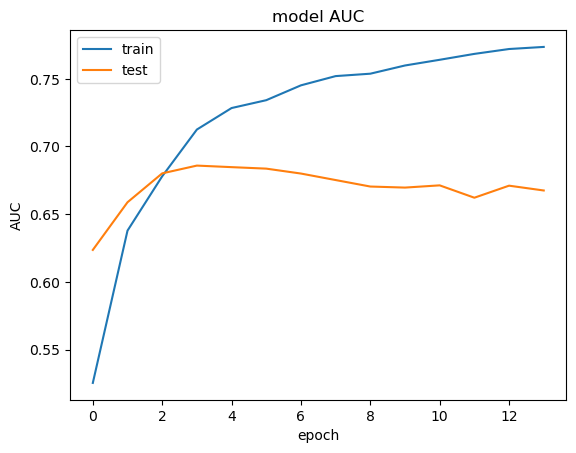

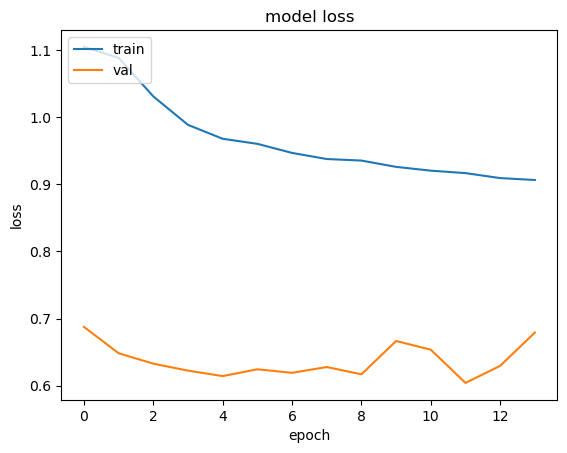

In [52]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
# plt.ylim(0.3, 1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
with tf.device('/CPU:0'):
    model.evaluate(X_eval, y_eval)
    model.evaluate(X_test, y_test)
    model.evaluate(X_testWales, y_testWales)
    model.evaluate(X_testScotland, y_testScotland)

14/14 [==============================] - 0s 7ms/step - loss: 0.6487 - auc: 0.5806


In [54]:
#Model evaluation function
def summariseResult (testY, preds):
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    aucscore = auc(fpr, tpr)
    # aucscore = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)

data_test_Xs = [X_eval, X_test, X_testWales, X_testScotland]
data_test_ys = [y_eval, y_test, y_testWales, y_testScotland]
for data_test_X, data_test_y in zip(data_test_Xs, data_test_ys):
    with tf.device('/CPU:0'):
        preds = model.predict(data_test_X)
    preds = [0 if pred <0.5 else 1 for pred in preds]
    print(summariseResult(data_test_y, np.squeeze(preds)))

76/76 [==============================] - 1s 7ms/step
(0.7099, 0.7694, 0.4755, 0.6225, 0.2696, 0.6225, 0.399, 34.3658, 85.2468)
40/40 [==============================] - 0s 6ms/step
(0.6595, 0.7492, 0.4257, 0.5874, 0.327, 0.5874, 0.4093, 39.418, 77.2881)
27/27 [==============================] - 0s 6ms/step
(0.6623, 0.7385, 0.4661, 0.6023, 0.3399, 0.6023, 0.4356, 40.8922, 78.087)
14/14 [==============================] - 0s 6ms/step
(0.6539, 0.7705, 0.3421, 0.5563, 0.3014, 0.5563, 0.3498, 35.7798, 75.8065)


In [55]:
model.save('../SeqModel/model_therapy.h5')

/opt/conda/envs/rapids/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# from keras.models import load_model
# a = load_model('../SeqModel/my_model.h5')